In [1]:
import os
import torch
import torchvision.datasets as dset
from torch.distributions import Bernoulli
import torchvision.transforms as transforms
import numpy as np
import random
from matplotlib import pyplot as plt
from scipy.stats import halfnorm

# Deep Reinforcement Learning _in Action_
## MNIST Genetic Algorithm

Setup a directory to store the MNIST dataset/

In [2]:
root = './data'
if not os.path.exists(root):
    os.mkdir(root)

Setup a transformer to normalize the data.

In [3]:
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])

In [4]:
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 135kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.94MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

We define a simple linear classifier (or you can think of it as a single layer neural network). It simply multiplies a weight/parameter matrix by the input vector and applies a softmax.

In [6]:
x = next(iter(train_loader))[0]

In [7]:
x = x.reshape(100,784)

In [8]:
class Individual:
    def __init__(self,param, fitness=0):
        self.param = param
        self.fitness = fitness

In [9]:
def model(x,W):
    return torch.nn.Softmax()(x @ W)

In [10]:
model(x,torch.rand(784,10))

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1736: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


tensor([[8.0415e-02, 8.1564e-01, 1.2993e-04, 9.6205e-06, 4.2607e-02, 3.4510e-03,
         1.3468e-07, 1.9071e-02, 2.5992e-06, 3.8671e-02],
        [3.2615e-03, 3.4417e-01, 4.7348e-03, 1.3144e-05, 1.3643e-02, 1.4172e-02,
         3.9150e-09, 5.4895e-01, 4.4521e-04, 7.0611e-02],
        [4.4648e-03, 7.6824e-02, 7.2382e-05, 5.6112e-07, 1.2557e-03, 2.3035e-02,
         1.1520e-06, 6.4408e-02, 4.3808e-01, 3.9186e-01],
        [8.5329e-03, 4.1015e-02, 1.2636e-05, 1.2556e-02, 4.1619e-02, 2.5481e-03,
         1.5834e-06, 7.6383e-01, 1.1411e-01, 1.5775e-02],
        [3.8271e-03, 9.6311e-01, 2.7506e-04, 6.0384e-08, 6.0083e-03, 4.0148e-05,
         2.8470e-07, 2.4852e-02, 1.2288e-05, 1.8718e-03],
        [3.0855e-04, 9.6496e-01, 4.7564e-06, 3.5664e-08, 3.9281e-03, 4.3679e-04,
         1.5278e-07, 5.1244e-03, 2.5232e-06, 2.5238e-02],
        [1.3340e-03, 9.1259e-01, 6.6844e-04, 3.8541e-08, 6.2315e-02, 4.9240e-05,
         1.1281e-08, 3.8940e-03, 7.3159e-05, 1.9081e-02],
        [1.1898e-03, 6.2337

In [11]:
def spawn_population(param_size=(784,10),pop_size=1000):
    return [Individual(torch.randn(*param_size)) for i in range(pop_size)]

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

In [13]:
random.randint(0,10)

5

In [14]:
def evaluate_population(pop):
    avg_fit = 0 #avg population fitness
    for individual in pop:
        x,y = next(iter(train_loader))
        pred = model(x.reshape(batch_size,784),individual.param)
        loss = loss_fn(pred,y)
        fit = loss
        individual.fitness = 1.0 / fit
        avg_fit += fit
    avg_fit = avg_fit / len(pop)
    return pop, avg_fit

In [15]:
def recombine(x1,x2): #x1,x2 : Individual
    w1 = x1.param.view(-1) #flatten
    w2 = x2.param.view(-1)
    cross_pt = random.randint(0,w1.shape[0])
    child1 = torch.zeros(w1.shape)
    child2 = torch.zeros(w1.shape)
    child1[0:cross_pt] = w1[0:cross_pt]
    child1[cross_pt:] = w2[cross_pt:]
    child2[0:cross_pt] = w2[0:cross_pt]
    child2[cross_pt:] = w1[cross_pt:]
    child1 = child1.reshape(784,10)
    child2 = child2.reshape(784,10)
    c1 = Individual(child1)
    c2 = Individual(child2)
    return [c1,c2]

In [16]:
def mutate(pop, mut_rate=0.01):
    param_shape = pop[0].param.shape
    l = torch.zeros(*param_shape)
    l[:] = mut_rate
    m = Bernoulli(l)
    for individual in pop:
        mut_vector = m.sample() * torch.randn(*param_shape)
        individual.param = mut_vector + individual.param
    return pop

In [17]:
def seed_next_population(pop,pop_size=1000, mut_rate=0.01):
    new_pop = []
    while len(new_pop) < pop_size: #until new pop is full
        parents = random.choices(pop,k=2, weights=[x.fitness for x in pop])
        offspring = recombine(parents[0],parents[1])
        new_pop.extend(offspring)
    new_pop = mutate(new_pop,mut_rate)
    return new_pop

In [18]:
pop = spawn_population()

In [19]:
%%time
pop, avg_fit = evaluate_population(pop)

CPU times: user 23.9 s, sys: 54.7 ms, total: 24 s
Wall time: 24.1 s


In [20]:
new_pop = seed_next_population(pop)

In [21]:
len(new_pop)

1000

Now we need to spawn a population of weight matrices, run the model using the different individuals, calculate the loss for each one, and then breed the ones with the highest fitness score (lowest loss).

In [22]:
num_generations = 50
population_size = 100
mutation_rate = 0.001 # 1% mutation rate per generation

### Main Evolution (Training) Loop

In [23]:
pop_fit = []
pop = spawn_population(pop_size=population_size) #initial population
for gen in range(num_generations):
    # trainning
    pop, avg_fit = evaluate_population(pop)
    pop_fit.append(avg_fit) #record population average fitness
    new_pop = seed_next_population(pop, pop_size=population_size, mut_rate=mutation_rate)
    pop = new_pop

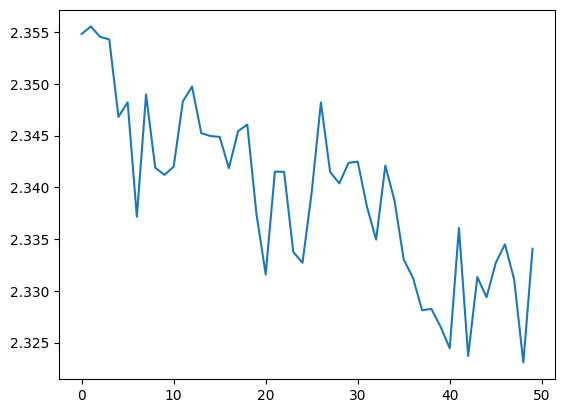

In [24]:
plt.plot(pop_fit)

In [25]:
avg_loss = 0
for i in range(len(pop)):
    x,y = next(iter(train_loader))
    pred = model(x.reshape(batch_size,784),pop[i].param)
    loss = loss_fn(pred,y)
    avg_loss += loss
avg_loss /= len(pop)
print(avg_loss)

tensor(2.3289)


Avg Loss new pop: 2.3336
Avg Loss after 10 gens: 2.3435

## Train with gradient-descent (comparison)

In [26]:
p = torch.randn(784,10, requires_grad=True)
optim = torch.optim.Adam(lr=0.1, params=[p])

tensor(2.2300, grad_fn=<NllLossBackward0>)
tensor(2.3311, grad_fn=<NllLossBackward0>)
tensor(2.2909, grad_fn=<NllLossBackward0>)
tensor(2.2810, grad_fn=<NllLossBackward0>)
tensor(2.3211, grad_fn=<NllLossBackward0>)
tensor(2.2408, grad_fn=<NllLossBackward0>)
tensor(2.2709, grad_fn=<NllLossBackward0>)
tensor(2.2610, grad_fn=<NllLossBackward0>)
tensor(2.2308, grad_fn=<NllLossBackward0>)
tensor(2.2212, grad_fn=<NllLossBackward0>)
tensor(2.2611, grad_fn=<NllLossBackward0>)
tensor(2.2409, grad_fn=<NllLossBackward0>)
tensor(2.2712, grad_fn=<NllLossBackward0>)
tensor(2.2510, grad_fn=<NllLossBackward0>)
tensor(2.3012, grad_fn=<NllLossBackward0>)
tensor(2.2512, grad_fn=<NllLossBackward0>)
tensor(2.2412, grad_fn=<NllLossBackward0>)
tensor(2.2811, grad_fn=<NllLossBackward0>)
tensor(2.3212, grad_fn=<NllLossBackward0>)
tensor(2.2712, grad_fn=<NllLossBackward0>)
tensor(2.2812, grad_fn=<NllLossBackward0>)
tensor(2.3312, grad_fn=<NllLossBackward0>)
tensor(2.3112, grad_fn=<NllLossBackward0>)
tensor(2.29

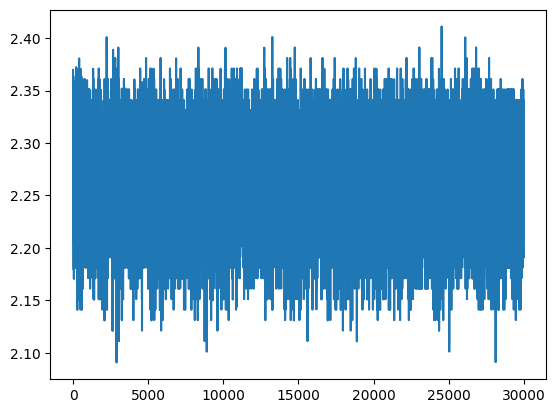

In [27]:
loss_list = []
for i in range(50):
    for x, y in train_loader:
        optim.zero_grad()
        pred = model(x.reshape(batch_size, 784), p)
        loss = loss_fn(pred, y)
        loss_list.append(loss.detach().numpy())  # Detach and convert to NumPy
        loss.backward()
        optim.step()
    print(loss)

plt.plot(loss_list)
plt.show()
